In [88]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# from IPython.display import display
# pd.set_option('display.max_rows', 10)

In [89]:
pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [90]:
### https://saturncloud.io/blog/how-to-change-the-path-in-google-colab/
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/dataset')

pwd = '/content/drive/My Drive/Colab Notebooks/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## for weather data
# def data_preparation(data_name):
#     df = pd.read_csv(data_name)
#     sample_size = 50000
#     if data_name == 'shifts_canonical_train.csv':
#         df = df.sample( n = 80000, random_state = 1 , ignore_index = True)
#     else:
#         df = df.sample( n = sample_size, random_state = 1 , ignore_index = True)

#     df = df.dropna()

#     y = df['fact_temperature'].to_numpy()
#     y = y.reshape(-1,1)
#     df = df.iloc[:,6:]
#     X = df.to_numpy()
#     return X, y


In [91]:
def data_preparation(data):
    df = pd.read_csv(data)
    if data == "train.csv":
      df = df.sample(n= 40000, random_state=1)
    y = df.pop('power')
    y = y.to_numpy()
    y = y.reshape(-1,1)
    X = df.to_numpy()
    return X, y

In [92]:
seed = 23
X, y = data_preparation('train.csv')

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= seed)

scaler1 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train)
X_val = scaler1.transform(X_val)
X_test = scaler1.transform(X_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_val = scaler2.transform(y_val)
y_test = scaler2.transform(y_test)
X_train.shape

(28800, 11)

In [94]:
X_small_shift, y_small_shift = data_preparation('dev_in.csv')
X_large_shift, y_large_shift = data_preparation('dev_out.csv')

In [95]:
def normalization(X, y):
  scaler_1 = MinMaxScaler()
  scaler_2 = MinMaxScaler()
  X = scaler1.fit_transform(X)
  y = scaler2.fit_transform(y)
  return X, y

X_small_shift, y_small_shift = normalization(X_small_shift, y_small_shift)
X_large_shift, y_large_shift = normalization(X_large_shift, y_large_shift)

In [96]:
# OOD data 1
OOD_1 = pd.read_csv('Boston.csv')
OOD_1 = OOD_1.to_numpy()


In [97]:
# OOD data 2
OOD_2 = pd.read_csv('naval.csv')
OOD_2 = OOD_2.to_numpy()
OOD_2.shape

(11934, 11)

In [ ]:
# df_describe = pd.DataFrame(X_train)
# df_describe.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000,28800.000000
mean,0.650062,0.690383,0.653303,0.499782,0.544147,0.313352,0.500530,0.498683,0.292670,0.555636,0.555636
std,0.214881,0.197573,0.157070,0.042184,0.170548,0.237956,0.118508,0.085208,0.162205,0.265017,0.265017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.489362,0.539773,0.536877,0.475000,0.416376,0.121242,0.452119,0.460916,0.179511,0.368564,0.368564
50%,0.695035,0.738636,0.712665,0.500000,0.540255,0.253674,0.502471,0.496818,0.273519,0.584981,0.584981
75%,0.815603,0.852273,0.759804,0.525000,0.671184,0.460039,0.549502,0.535077,0.384339,0.779665,0.779665
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
import matplotlib.pyplot as plt
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
tf.autograph.set_verbosity(0)
import official.nlp.modeling.layers as nlp_layers

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [99]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [100]:
resnet_config = dict(num_classes = 1, num_layers= 3, num_hidden= 512)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build( (None, 11) )
resnet_model.summary()

Model: "deep_res_net_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            multiple                  6144      
                                                                 
 dense_60 (Dense)            multiple                  262656    
                                                                 
 dense_61 (Dense)            multiple                  262656    
                                                                 
 dense_62 (Dense)            multiple                  262656    
                                                                 
 dense_63 (Dense)            multiple                  513       
                                                                 
Total params: 794625 (3.03 MB)
Trainable params: 788481 (3.01 MB)
Non-trainable params: 6144 (24.00 KB)
_________________________________________________________________


In [101]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

fit_config = dict(batch_size= 512,  epochs= 1000,
                validation_data = (X_val, y_val),
                callbacks=[callback] )

In [102]:
resnet_model.compile(**train_config)
history = resnet_model.fit( x = X_train, y = y_train,
                           **fit_config )

Epoch 1/2
57/57 [==============================] - 8s 102ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 2/2
57/57 [==============================] - 8s 140ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0037 - val_mean_squared_error: 0.0037


<Axes: >

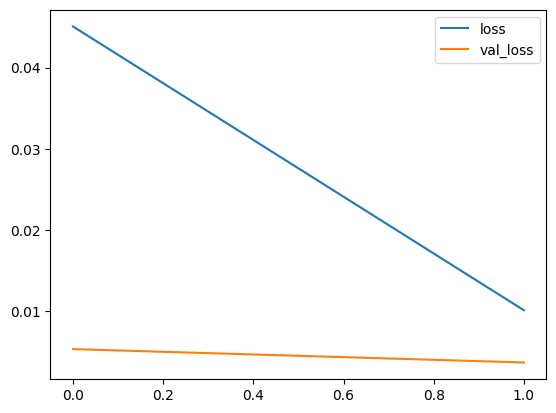

In [103]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

# print(("Best Validation Loss: {:0.4f}" +\
#       "\nBest Validation Accuracy: {:0.4f}")\
#       .format(history_df['val_loss'].min(),
#               history_df['val_sparse_categorical_accuracy'].max()))

In [104]:
resnet_model.evaluate(X_test, y_test)

250/250 [==============================] - 2s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036


[0.0035937661305069923, 0.0035937661305069923]

In [105]:
resnet_model.evaluate(X_small_shift, y_small_shift)

574/574 [==============================] - 3s 5ms/step - loss: 0.0037 - mean_squared_error: 0.0037


[0.003727888921275735, 0.003727888921275735]

In [106]:
resnet_model.evaluate(X_large_shift, y_large_shift)

574/574 [==============================] - 4s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0066


[0.006649095099419355, 0.006649095099419355]

In [ ]:
#resnet_model.evaluate( scaler1.inverse_transform(X_test), scaler2.inverse_transform(y_test) )

In [107]:
import official.nlp.modeling.layers as nlp_layers

In [108]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [ ]:
# Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [109]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [110]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [ ]:
# Train model

In [111]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

Epoch 1/2
57/57 [==============================] - 14s 218ms/step - loss: 0.0240 - mean_squared_error: 0.0173 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 2/2
57/57 [==============================] - 6s 108ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0070 - val_mean_squared_error: 0.0070


<Axes: >

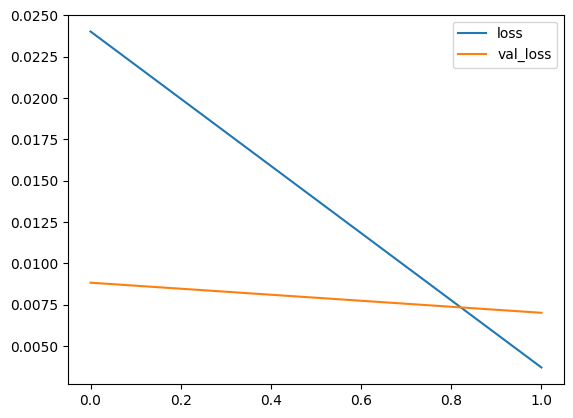

In [112]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()

In [113]:
# # This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:

def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return logits_adjusted

In [114]:
from sklearn.metrics import mean_squared_error
def compute_results(model, X_test, y_test):
    sngp_logits, sngp_covmat = model(X_test, return_covmat=True)
    sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
    std = np.sqrt(sngp_variance)
    std = np.mean(std)
    sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
    mse = mean_squared_error(sngp_probs, y_test)
    print(f'std: {std} -- mse:{mse}')
    return std, mse
compute_results(sngp_model, X_test, y_test)

std: 0.07063746452331543 -- mse:0.007055487029873232


(0.070637465, 0.007055487029873232)

In [115]:
compute_results(sngp_model, X_small_shift, y_small_shift)

std: 0.07067504525184631 -- mse:0.006154493382048185


(0.070675045, 0.006154493382048185)

In [116]:
compute_results(sngp_model, X_large_shift, y_large_shift)

std: 0.10502013564109802 -- mse:0.006176601734295981


(0.105020136, 0.006176601734295981)

In [117]:
# MC Dropout
import seaborn as sns

In [118]:
num_ensemble = 10

In [119]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

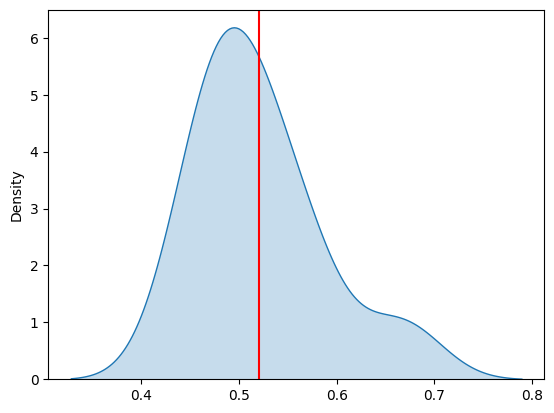

std: 0.0658523291349411 -- mse:0.004117703206875834


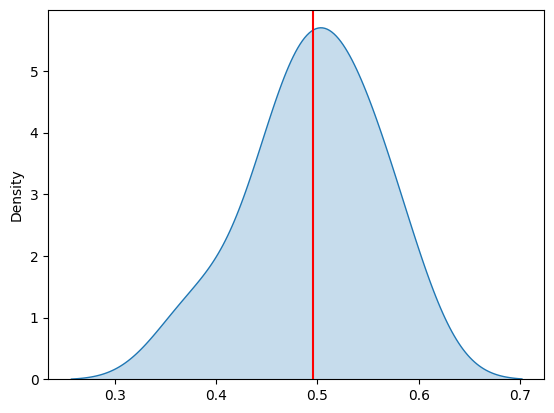

std: 0.06596332043409348 -- mse:0.004334894668570083


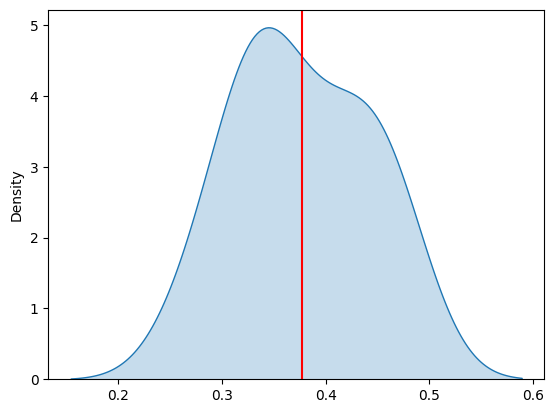

std: 0.0693574845790863 -- mse:0.007153703871068069


(0.069357485, 0.007153703871068069)

In [120]:
# Monte Carlo dropout inference.
def compute_mcdrop_out_results(model, X, y):
  pred_list = np.hstack([model(X) for _ in range(num_ensemble)])
  pred = pred_list.mean(axis = 1)

  # Plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.axvline(pred[0], color='red')
  plt.show()

  mse = mean_squared_error(pred, y)
  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)

  print(f'std: {std} -- mse:{mse}')
  return std, mse

compute_mcdrop_out_results(mc_dropout_sampling, X_test, y_test )
compute_mcdrop_out_results(mc_dropout_sampling, X_small_shift, y_small_shift )
compute_mcdrop_out_results(mc_dropout_sampling, X_large_shift, y_large_shift )

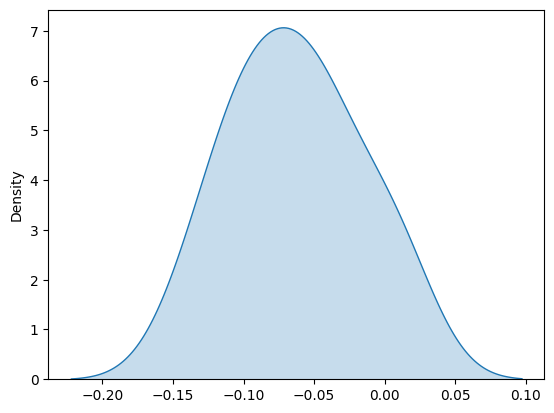

std -- 0.06434928625822067


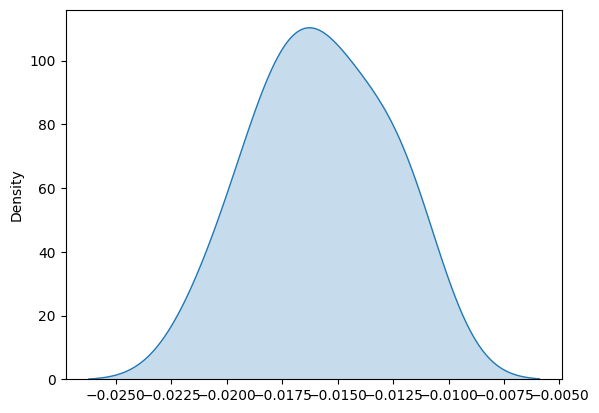

std -- 0.04769206419587135


0.047692064

In [122]:
def ood_uncertainty_mcdropout(model, ood_data):
  pred_list = np.hstack([model(ood_data) for _ in range(num_ensemble)])

  # plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.show()

  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)
  print(f'std -- {std}')
  return std

ood_uncertainty_mcdropout(mc_dropout_sampling, OOD_1)
ood_uncertainty_mcdropout(mc_dropout_sampling, OOD_2)

In [ ]:
# Deep ensemble

In [123]:
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)
  resnet_ensemble.append(resnet_model)

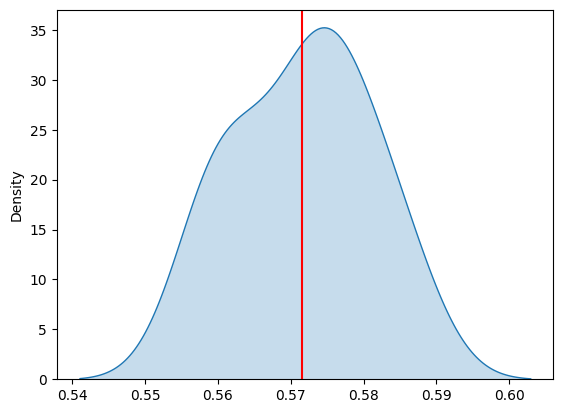

std: 0.012373815290629864 -- mse:0.0027913118399063024


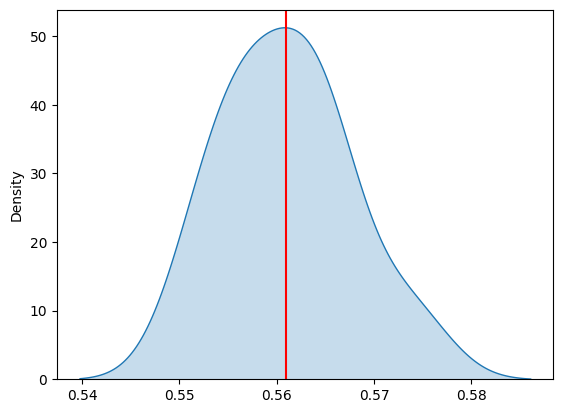

std: 0.012354490347206593 -- mse:0.0030737288782652947


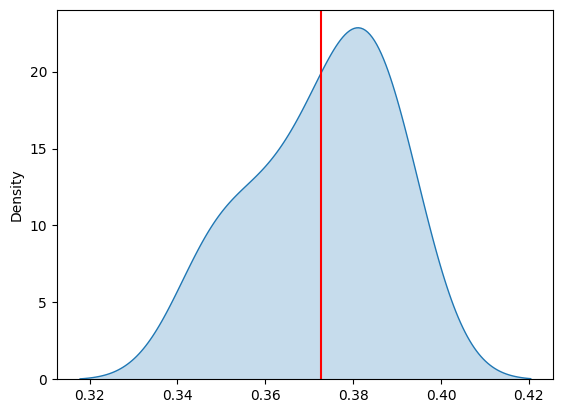

std: 0.014005565084517002 -- mse:0.005668809286310198


(0.014005565, 0.005668809286310198)

In [124]:
def compute_deep_ensemble_results(model_list, X, y):
  pred_list  = np.hstack([model(X) for model in model_list])
  pred = pred_list.mean(axis = 1)

  # plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.axvline(pred[0], color='red')
  plt.show()

  mse = mean_squared_error(pred, y)
  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)

  print(f'std: {std} -- mse:{mse}')
  return std, mse

compute_deep_ensemble_results(resnet_ensemble, X_test, y_test)
compute_deep_ensemble_results(resnet_ensemble, X_small_shift, y_small_shift)
compute_deep_ensemble_results(resnet_ensemble, X_large_shift, y_large_shift)

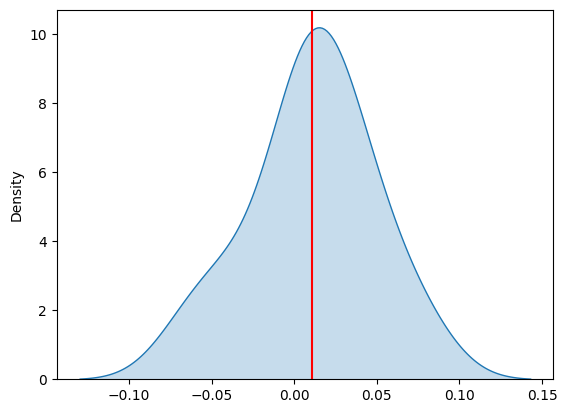

std -- 0.052582766860723495


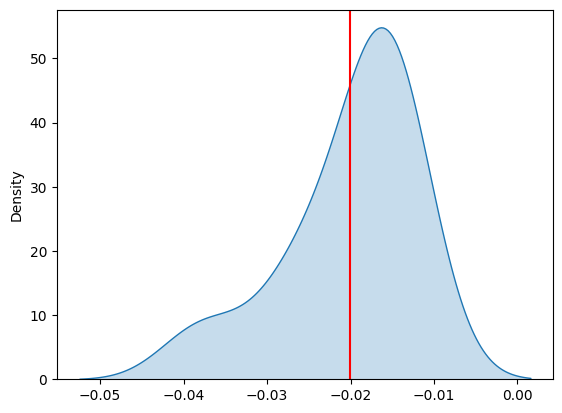

std -- 0.01115963701158762


0.011159637

In [125]:
def ood_uncertainty_deep_ensemble(model_list, ood_data):
  pred_list  = np.hstack([model(ood_data) for model in model_list])
  pred = pred_list.mean(axis = 1)
  # plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.axvline(pred[0], color='red')
  plt.show()
  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)

  print(f'std -- {std}')
  return std

ood_uncertainty_deep_ensemble(resnet_ensemble, OOD_1)
ood_uncertainty_deep_ensemble(resnet_ensemble, OOD_2)